In [1]:
from IPython.display import Image
import itertools

import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

## Adaptive Computation Inference Networks

The idea is to use a 
$$ \theta_{i}^{l+1} \leftarrow \theta_{i}^{l} + \epsilon \boldsymbol{\hat \phi}(\theta_{i}^{l}) \text{  where  } \boldsymbol{\hat \phi}(\theta_{i}^{l}) = \frac{1}{n} \sum_{j=1}^{n} k(\theta_{j}^{l}, \theta) \nabla_{\theta_{j}^{l}} \log p(\theta_{j}^{l}) + \nabla_{\theta_{j}^{l}} k(\theta_{j}^{l}, \theta)$$
where $k$ is a valid kernel and $\epsilon$ is a step-size.  The operator $\boldsymbol{\hat \phi}(\theta_{i}^{l})$ is implemented below:

### Gaussian Mixture Model

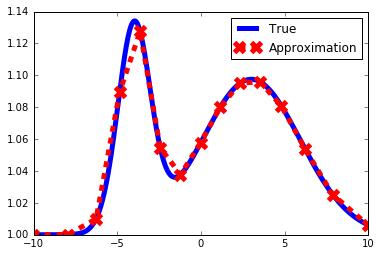

In [7]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})
                                         
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# kernel
kernel = {'f': rbf}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.normal

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0())
    
maxEpochs = 100
lr = 2.
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.xlim([-10,10])
plt.legend()